# Bayesian Decision Theory

In this lab, we will create generative models of data. The data that we will use is the same as in the lab on logistic regression, and we will create a model where we use 2-dimensional Gaussian distributions to describe the data in each class. We then use Bayes' rule to compute the probability of a datapoint belonging to a certain class.

The code below loads the data and provides you with an effective, simple to understand and simple to use implementation of the Gaussian PDF. 

So, first, let's load the data.

In [1]:

import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import operator
import pylab
import math

pylab.rcParams['figure.figsize'] = (13.0, 10.0)


In [2]:
# This code is given

data = np.load("data-2c.npz")
d = data['d']
l = data['l']

colours = [ [ 'r', 'b' ][int(x)] for x in np.nditer(l)]

# Our own implementation of the multivariate Gaussian Distribution
class Gauss:
    def __init__(self, mu, sigma):
        """Initialise a distribution with mean mu and covariance sigma
        
        Precompute and store everything that is not dependent
        on the datapont, so as to keep things efficient
        
        mu:    Mean vector
        sigma: Covariance matrix
        """
        D = mu.size
        
        self.mu = mu
        self.icov = np.linalg.inv(sigma)
        sign,ld = np.linalg.slogdet(sigma)
        if sign != 1:
            print("Sign=",sign)
        
        self.lognum = D*np.log(2*np.pi) + ld
                            
    def logprob(self,x, mu=None):
        """return log(p(x))
        x: data vector
        """
        if type(mu).__module__ == np.__name__:
            d = x-mu
        else:
            d = x-self.mu
        return -.5 * (self.lognum + np.dot(np.dot(d,self.icov),d))
    
    def prob(self,x,mu=None):
        """return p(x)
        x: data vector"""
        return np.exp(self.logprob(x,mu)) 

And here is some code for plotting the distribution in 2D

In [3]:
# Code for plotting the heat map
import time
from IPython import display

xx,yy = np.mgrid[-5:10:.1,-5:10:.1]
def plotHeat(f):
    """ Plot a heatmap for an arbitrary function"""
    display.clear_output(wait=True)
    display.display(plt.gcf())
    p = np.zeros(xx.shape)
    for i in range(xx.shape[0]):
        for j in range(xx.shape[1]):
            p[i,j] = f(xx[i,j], yy[i,j])
    plt.pcolor(xx,yy,p,cmap='seismic',shading="auto")
    plt.xlim([-5,10])
    plt.ylim([-5,10])
    plt.scatter(d[:,0],d[:,1],20,colours)
    time.sleep(.01)
    
def nn(x,y):
    """Return the label of the nearest datapoint
    
    WARNING: this naive implementation is slow
    """
    mindist = 1e200
    bestl = 0
    for p,t in zip(d, l):
        dist = (p[0]-x)**2+(p[1]-y)**2
        if dist<mindist:
            mindist = dist
            bestl = t
    return bestl

#plotHeat(nn)

## Unconstrained model

$$
\newcommand{\x}{\mathbf{x}}
\newcommand{\c}{\mathcal{C}}
\newcommand{\mean}{\boldsymbol{\mu}}
\newcommand{\cov}{\boldsymbol{\Sigma}}
$$

In this first exercise, we will create two normal distributions, one for each class. The probability density at a datapoint, given that it belongs to class one, is given by:
$$
p(\x|\c_1) = \frac{1}{\sqrt{(2\pi)^k |\cov_1|}} \exp-\frac12 (\x-\mean_1)^\top \cov_1^{-1} (\x-\mean_1)
$$
where $k$ is the dimensionality of the data (in this case, 2), $\mean_1$ is the mean of the data and $\cov_1$ is the covariance of the data. The probability density for a datapoint belonging to class two is given analogously, with its own parameters $\mean_2$ and $\cov_2$.

### Question 1
Split your dataset into 80\% training set and 20% test set. Using the train set, learn the two Gaussian distributions for the two classes. That is, implement a function to compute the sufficient statistics for the class-conditional distributions yourself. 

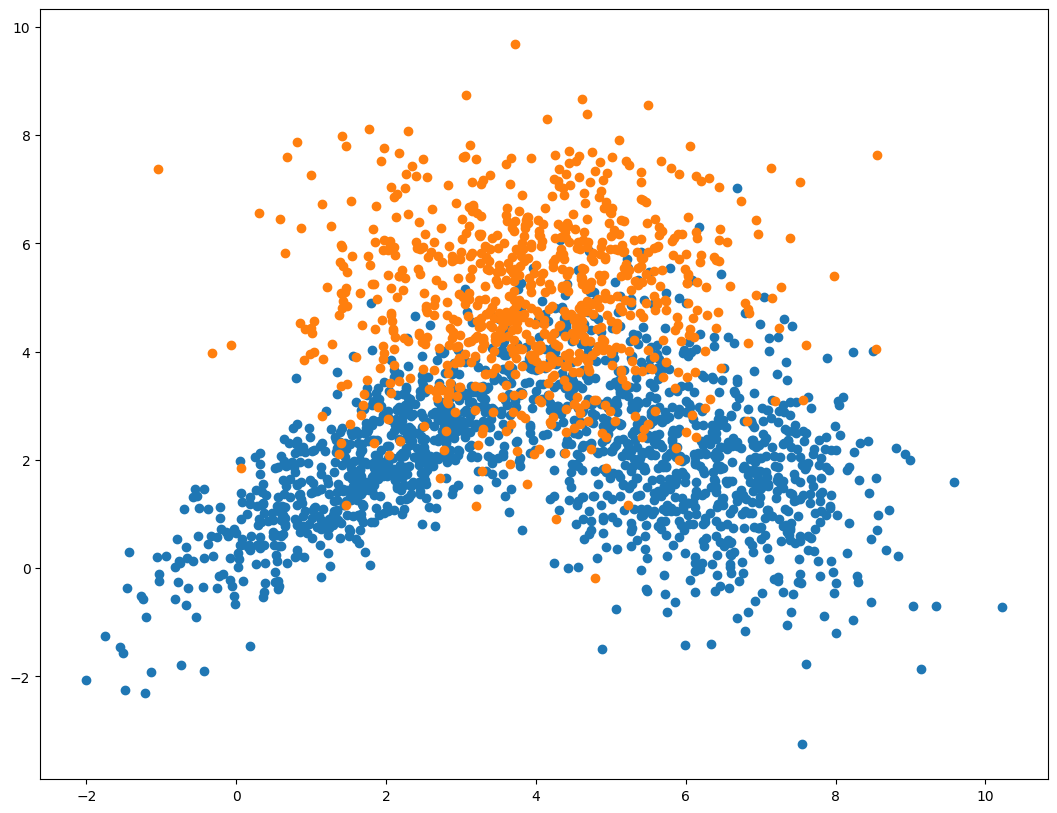

In [4]:
N=int(.8*d.shape[0])

train = d[:N,:]
test = d[N:,:]
traint = l[:N]
testt = l[N:]


def param(data):
    N = data.shape[0]
    mu = 0
    for x in data:
        mu += x
    mu /= N
    sigma = 0
    for x in data:
        delta = x-mu
        sigma += np.outer(delta,delta)
    sigma /= N
    return mu,sigma
    
data0 = train[traint==0,:]
data1 = train[traint==1,:]
plt.scatter(data0[:,0],data0[:,1])
plt.scatter(data1[:,0],data1[:,1])

#print(param(data0))
#print(param(data1))
#print(param(train))



###  Question 2
Use Bayes' rule to compute $p(\c_1|\x)$. Plot the posterior using the provided heatmap code. What is the performance of the model on the test set?

<Figure size 1300x1000 with 0 Axes>

Accuracy: 0.855


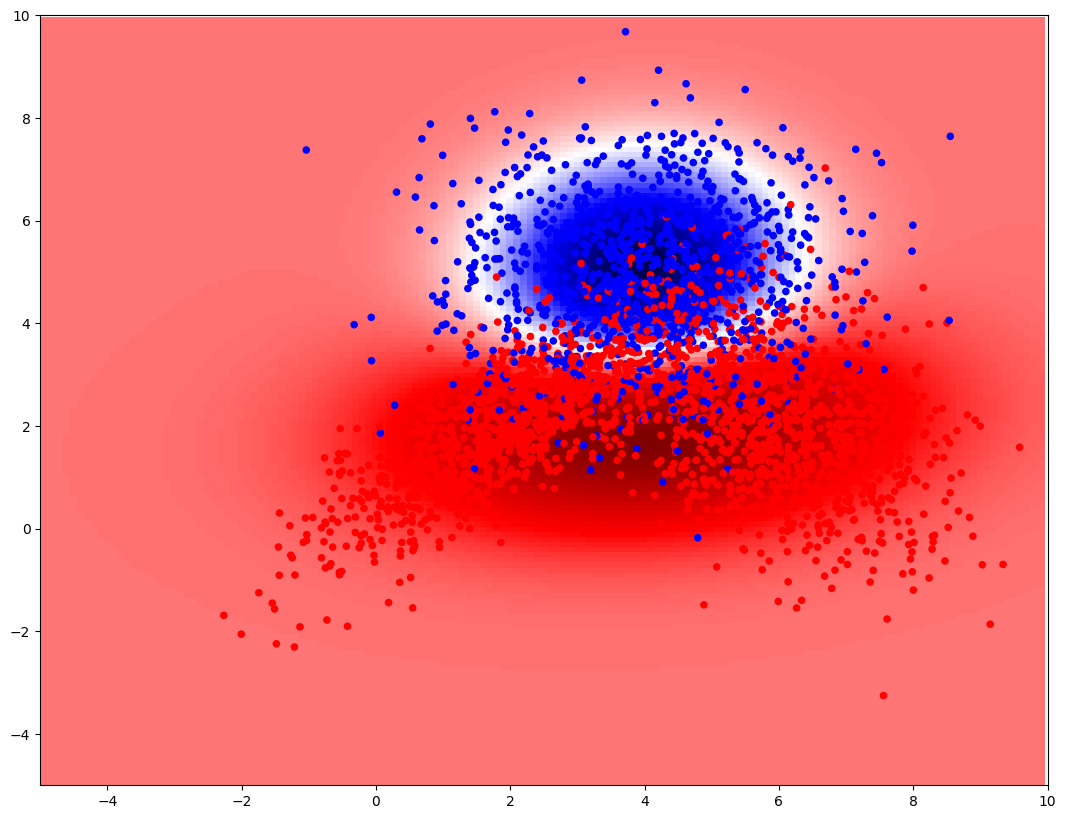

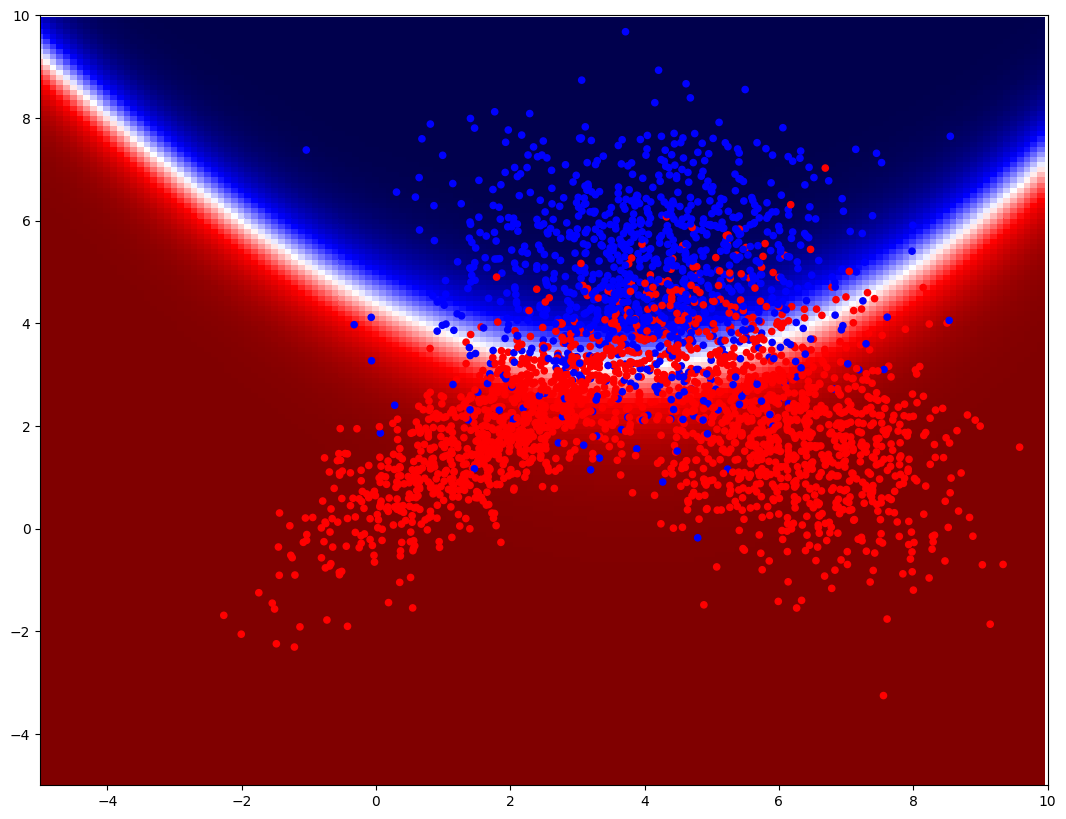

In [5]:

mu0,sigma0 = param(data0)
mu1,sigma1 = param(data1)

g0 = Gauss(mu0,sigma0)
g1 = Gauss(mu1,sigma1)

def lik(x,y):
    """
    Just for visualisation, let negative values correspond to Gauss 0
    and positive values to Gauss 1. """
    pt = np.array([x,y])
    return g0.prob(pt)-g1.prob(pt)
plotHeat(lik)
plt.figure()

def posterior(x,y):
    """
    p(c0 | x)
    """
    pt = np.array([x,y])
    p0 = g0.prob(pt)
    p1 = g1.prob(pt)
    return p0/(p0+p1)

plotHeat(posterior)

#def perf():
#    acc = 0
#    for x,t in zip(test,testt):
#        p0 = g0.prob(x)
#        p1 = g1.prob(x)
#        post = p0/(p0+p1)
#        if (post>.5 and t==0) or (post<.5 and t==1):
#            acc += 1
#    return acc/test.shape[0]

def perf(posterior):
    acc = 0
    for x,t in zip(test,testt):
        post = posterior(x[0],x[1])
        if (post>.5 and t==0) or (post<=.5 and t==1):
            acc += 1
    return acc/test.shape[0]


print("Accuracy:", perf(posterior))


## Constrained model

### Question 3
Now, let's look at a constrained model. How would you compute the means and covariances of the two classes, if you want to enforce that the covariances of the two classes are identical? Implement your answer, and plot the discriminant. What is the performance on the test set?

ANSQ3

The maximum-likelihood estimate of the covariance matrix is where the sum of the log-likelihoods for all datapoints is maximal (the product of the probability of all datapoints given the parameters is maximal). Both Gaussians have their own means, but the covariance matrix is shared: the maximum likelihood estimate is obtained as the averaged outer product of the difference of each datapoint and the corresponding mean. This is not the same as averaging the covariances, if both classes have different numbers datapoints. 




<Figure size 1300x1000 with 0 Axes>

Accuracy 0.8733333333333333


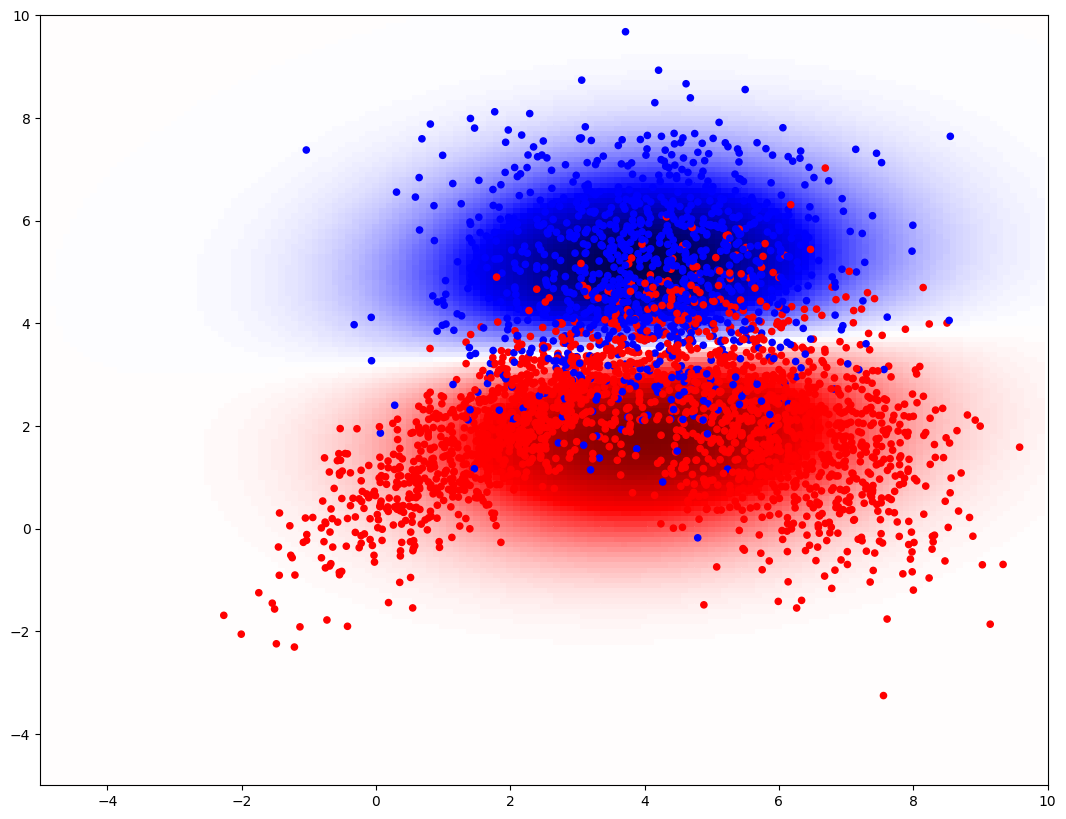

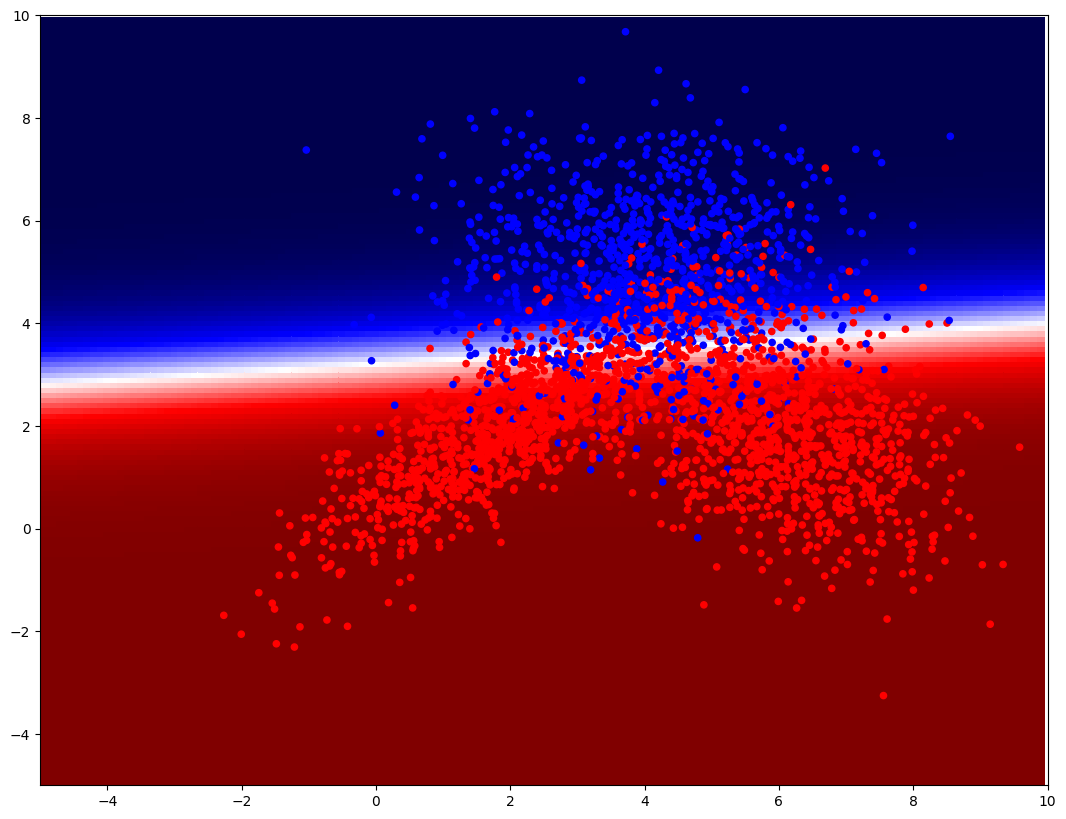

In [6]:
def sharedcov(data0,data1):
    N0 = data0.shape[0]
    N1 = data1.shape[0]
    mu0 = 0
    for x in data0:
        mu0 += x
    mu0 /= N0
    mu1 = 0
    for x in data1:
        mu1 += x
    mu1 /= N1
    
    sigma = 0
    for x in data0:
        delta = x-mu0
        sigma += np.outer(delta,delta)
    for x in data1:
        delta = x-mu1
        sigma += np.outer(delta,delta)
    sigma /= (N0+N1)
    return mu0,mu1,sigma    

m0,m1,s = sharedcov(data0,data1)

g0 = Gauss(m0,s)
g1 = Gauss(m1,s)

plotHeat(lik)
plt.figure()
plotHeat(posterior)
print("Accuracy",perf(posterior))


### Question 4

Let us enforce a different type of constraint. The covariances of both distributions are now not identical, but each covariance is diagonal (that is, the matrix contains only variances, not co-variances). Implement this and plot the distributions overlaid on the dataset. What is the performance on the test set? What does the discriminant look like?

<Figure size 1300x1000 with 0 Axes>

Accuracy 0.8516666666666667


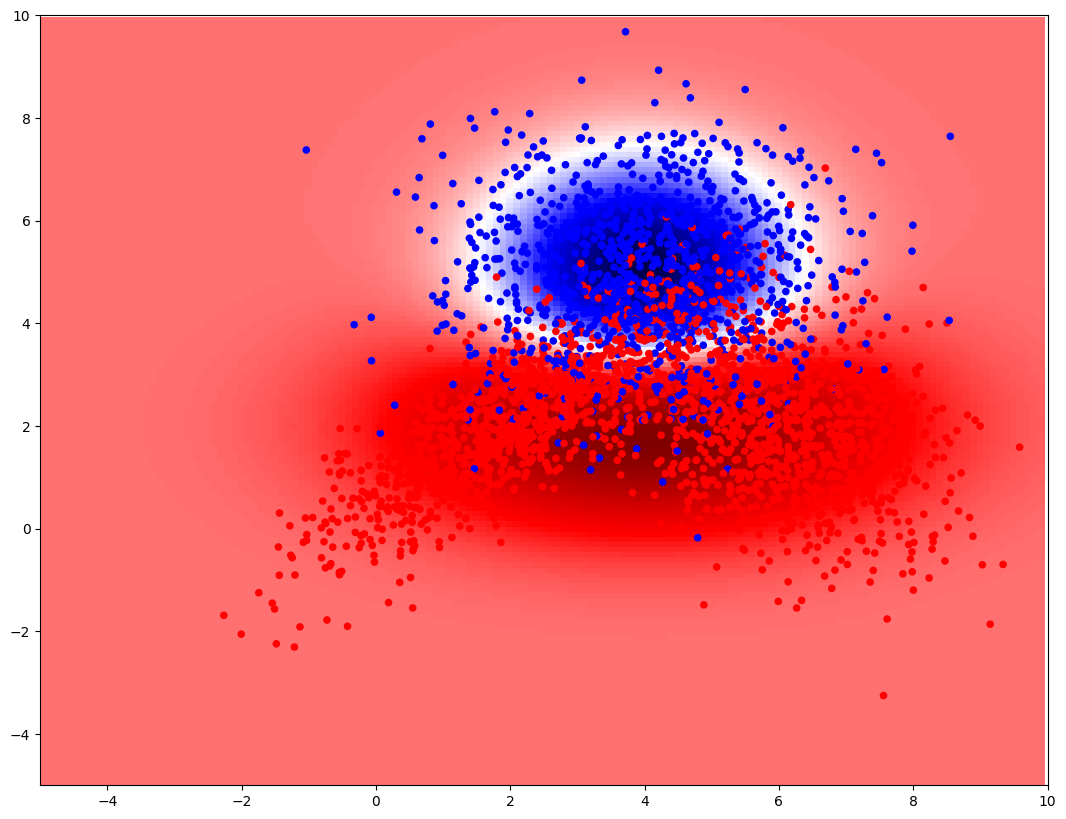

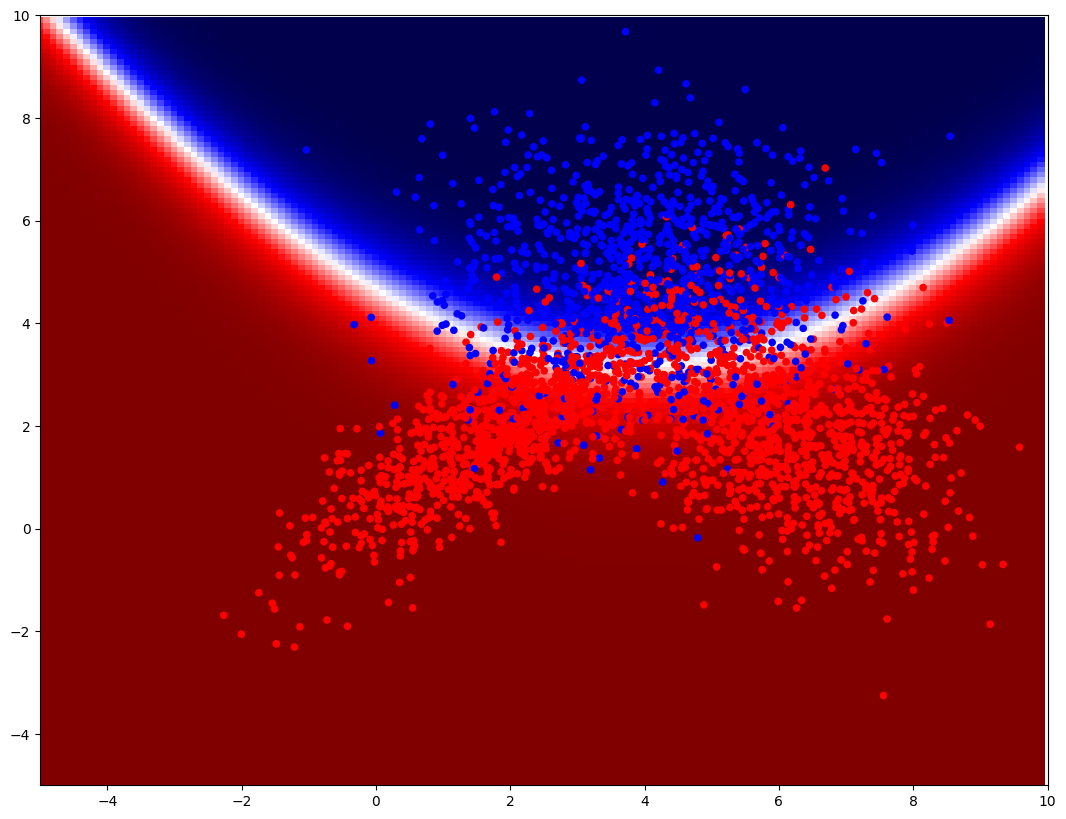

In [7]:

sigma0d = np.diag(np.diag(sigma0))
sigma1d = np.diag(np.diag(sigma1))

g0 = Gauss(mu0,sigma0d)
g1 = Gauss(mu1,sigma1d)

plotHeat(lik)
plt.figure()
plotHeat(posterior)
print("Accuracy",perf(posterior))


### Question 5

Finally, implement and test the model where you enforce spherical covariances. That is, there are no covariance terms in the matrix, and the variances are the same along all dimensions. Plot the distributions and the discriminant, and compute the performance on the test set.

<Figure size 1300x1000 with 0 Axes>

Accuracy 0.855


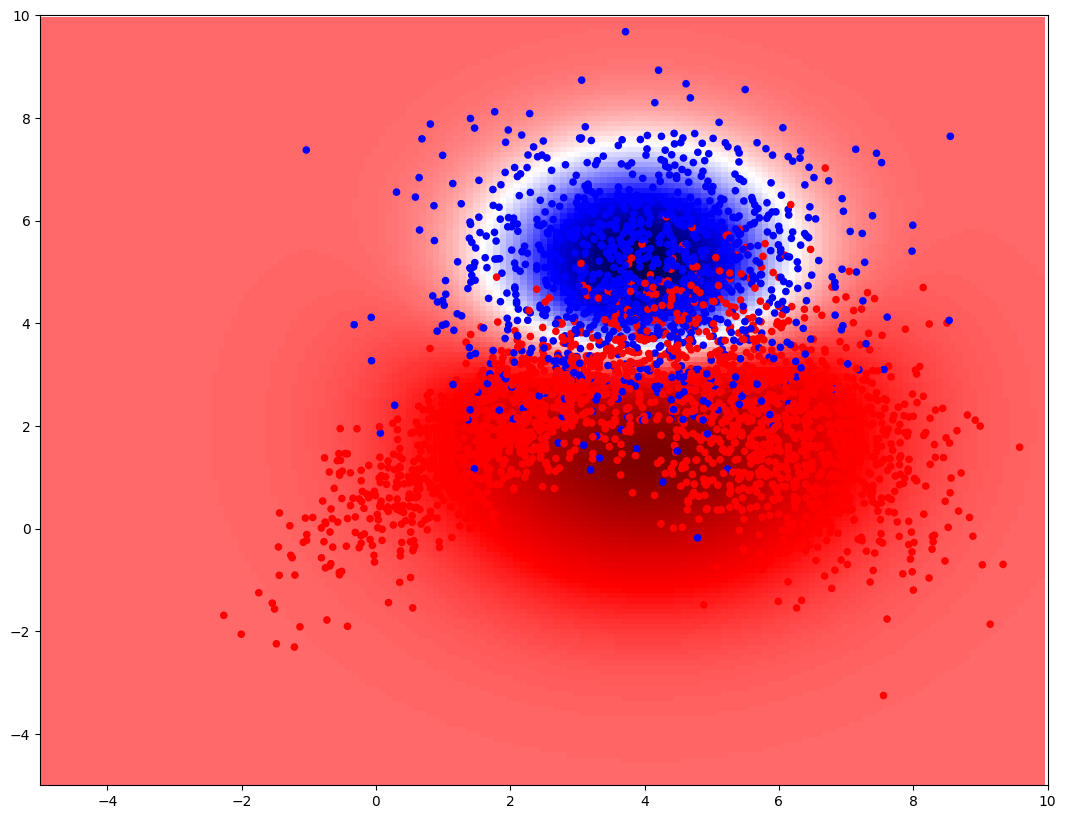

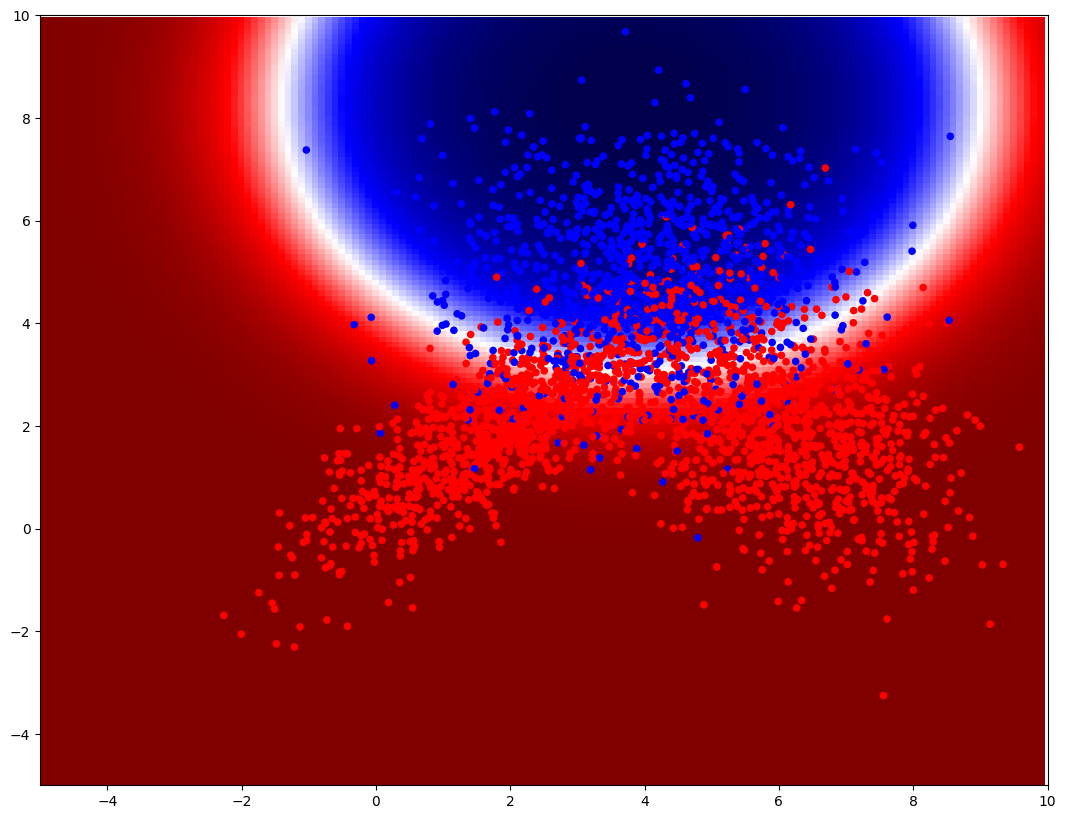

In [8]:

s0 = np.mean(sigma0d.diagonal())
sigma0d[0,0] = s0
sigma0d[1,1] = s0
s1 = np.mean(sigma1d.diagonal())
sigma1d[0,0] = s1
sigma1d[1,1] = s1


g0 = Gauss(mu0,sigma0d)
g1 = Gauss(mu1,sigma1d)

plotHeat(lik)
plt.figure()
plotHeat(posterior)
print("Accuracy",perf(posterior))


## Non-parametric model

For the next question, you will use the two-dimensional Gaussian distribution as a kernel. That is, we model the probability density at a datapoint $\x$ as:
$$
p(\x) = \frac{1}{N} \sum_i \frac{1}{\sqrt{(2\pi)^k |\cov|}} \exp -\frac12 (\x-\x_i)^\top \cov^{-1} (\x-\x_1)
$$
where the covariance matrix $\cov$ defines the width and shape of the kernel function and is not decided by the data. In this case, a spherical covariance matrix $\sigma I$ (where $I=\begin{bmatrix} 1 & \cdots & 0 \\ & \ddots & \\ 0 & \cdots & 1 \end{bmatrix}$)

### Question 6
As before, make two plots where you plot the likelihood and the posterior probability given the training data of both classes, using the Gaussian function as the kernel. To make things somewhat faster, you can use a subset of the training data. In addition, can create a single Gauss class with a given covariance matrix and zero mean, and call ``kernel.prob(x,xt)`` where ``xt`` is used as the mean of the Gaussian in the computation. 

How does $\sigma$ affect the performance of your modelyour model? 

<Figure size 1300x1000 with 0 Axes>

<Figure size 1300x1000 with 0 Axes>

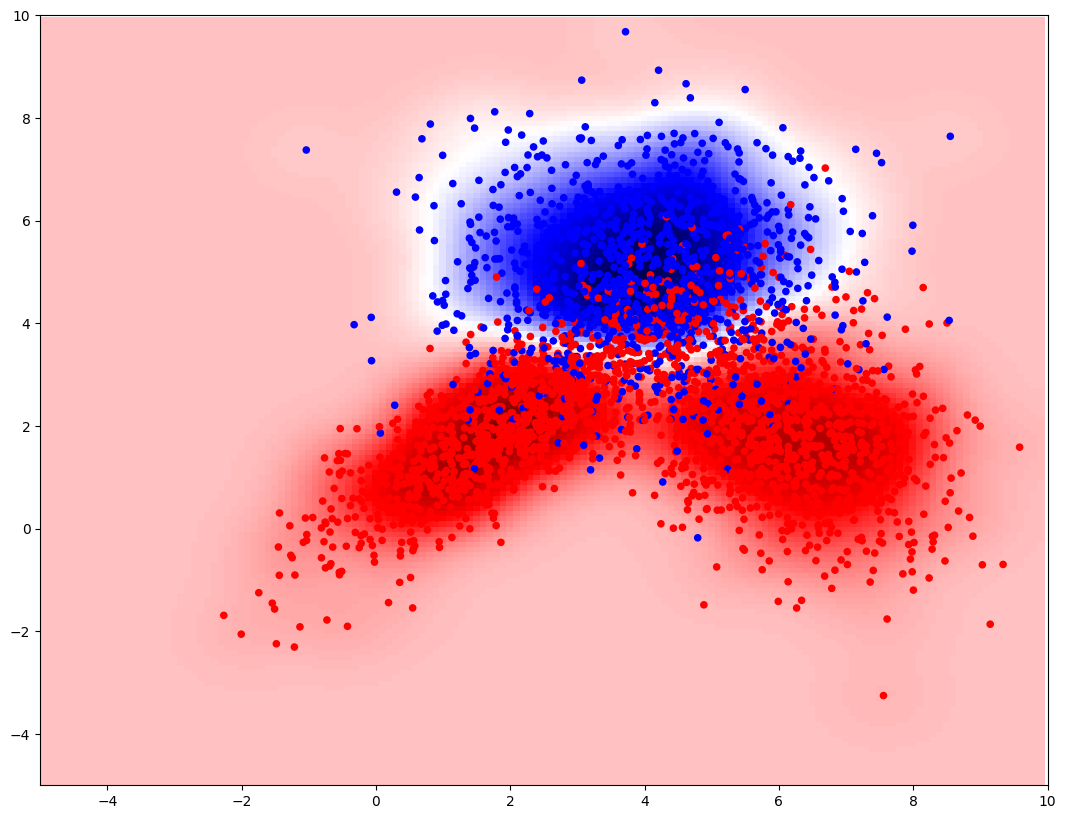

<Figure size 1300x1000 with 0 Axes>

In [9]:
kernel = Gauss(np.array([0,0]),.3*np.eye(2))

def p(x, data):
    prob = 0
    N = data.shape[0]
    for xp in data:
        prob += kernel.prob(x,xp)
        
    return prob/N
        
def lik(x,y):
    """
    Just for visualisation, let negative values correspond to Gauss 0
    and positive values to Gauss 1. """
    pt = np.array([x,y])
    return p(pt,data0[:500])-p(pt,data1[:500])

plotHeat(lik)
plt.figure()

<Figure size 1300x1000 with 0 Axes>

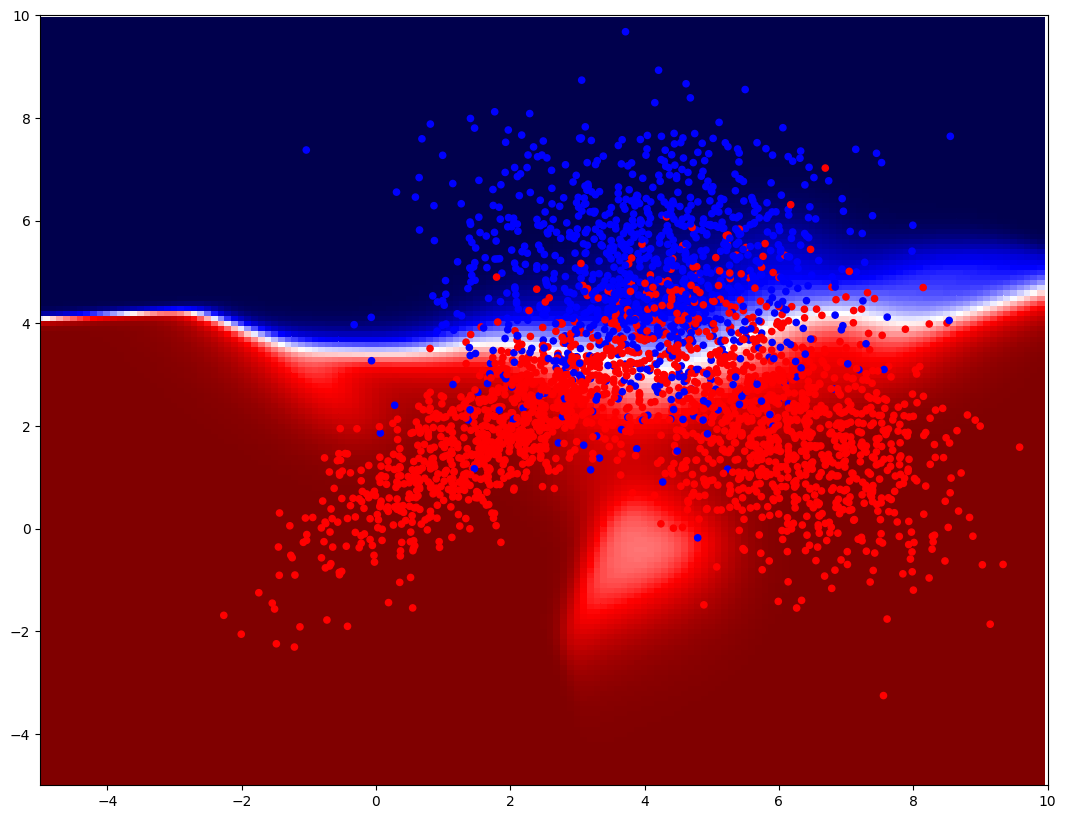

In [12]:
    
def posterior(x,y):
    pt = np.array([x,y])
    p0 = p(pt,data0[:500])
    p1 = p(pt,data1[:500])
    return p0/(p0+p1)

print("Performance:",perf(posterior))

plotHeat(posterior)

### Question 7

Implement approximating the expected value of an iris using the values and probabilities for the different varieties defined in the lecture:

| Variety | Value | Probability |
|---|---|--|
| A | 10 | .1 |
| B | 3 | .5 | 
| C | 2 | .4 |


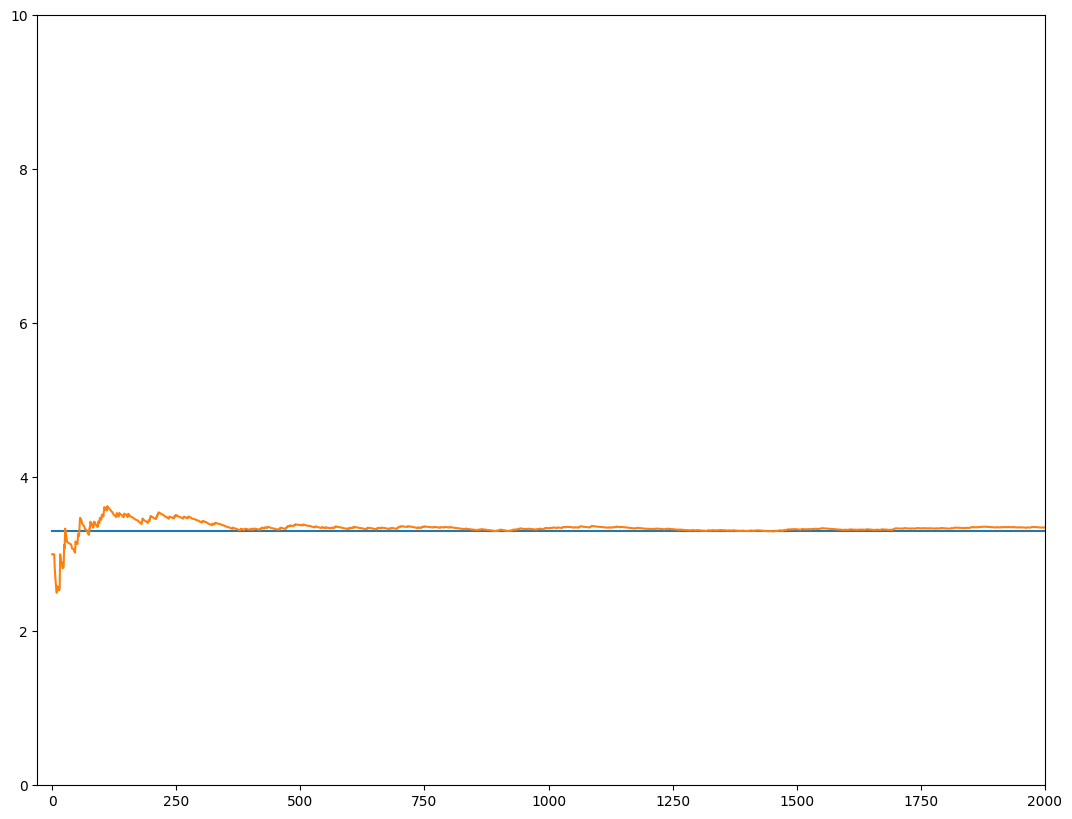

In [11]:
# Code for the sampling example in the lecture

probs = [.1,.5,.4]
vals  = [10, 3, 2]

def sample(probs):
    v = np.random.random()
    p=0.
    for i in range(len(probs)):
        p += probs[i]
        if p>=v:
            return i
    return len(probs)-1

expsum = 0
approx = []
for i in range(2000):
    s = sample(probs)
    expsum += vals[s]
    approx.append(expsum/(i+1))

plt.axis([-30, len(approx), 0, 10])
plt.plot([0,len(approx)],[3.3,3.3],range(len(approx)),approx)
plt.savefig("sample.pdf")
    